In [1]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
    
# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("rocket", as_cmap=True)
colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
colourmap.set_bad("black", alpha=0)

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0, 3]

You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\richa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [47]:
# Load patient 2
dat = alldat[0, 2]
# Selected channels of high correlations for patient 2
corr_chan = sorted([5, 23, 17, 1, 25])

V = dat['V']
V_corr = dat['V'][:,corr_chan]
nt, nchan = V_corr.shape
print(nt, nchan)

cx = dat['cursorX'].flatten()
cy = dat['cursorY'].flatten()

134360 5


In [96]:
# split into 80:20 train test split
nt, nchan = V_corr.shape

boundary = math.ceil(nt*0.8)

V_train = V_corr[:boundary, :]
V_test = V_corr[boundary:, :]

cx_train = cx[:boundary]
cx_test = cx[boundary:]
cy_train = cy[:boundary]
cy_test = cy[boundary:]

In [214]:
#Define linear regression functions
import numpy as np
from sklearn.linear_model import LinearRegression

def construct_matrices (_V, _cx, _cy, h, l):
    # Construct test matrices
    nt, nchan = _V.shape

    # Generate feature indices
    i0 = h*l
    iN = nt
    test_step = 1
    indices = range(i0, iN, test_step)

    # Generate 
    no_obs = len(indices)
    no_vars_rgand = 2    #Number of regressand variables (x and y)
    no_vars_rgor = len(corr_chan) * (h+1)

    regressand = np.zeros((no_obs, no_vars_rgand))
    regressor = np.zeros((no_obs, no_vars_rgor))

    for j, ind in enumerate(indices):
        regressand[j, 0] = _cx[ind]
        regressand[j, 1] = _cy[ind]
        for i, chan in enumerate(corr_chan):
            for h in range(hindsight+1):
                regressor[j, (hindsight+1)*i + h] = _V[ind - h * lag, i]
    return regressor, regressand

def LR_fit(regor, regand):
    reg = LinearRegression()
    reg.fit(regor, regand)
    #print('shape:', reg.coef_.shape)
    #print('score:', reg.score(regor, regand))
    return reg

def LR_predict(regor, _model):
    predict = _model.predict(regor[:,:])
    return predict

In [210]:
def LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    _regressor_train, _regressand_train = construct_matrices(_V_train, _cx_train, _cy_train, _h, _l)
    _regressor_test, _regressand_test = construct_matrices(_V_test, _cx_test, _cy_test, _h, _l)


    _model = LR_fit(_regressor_train, _regressand_train)
    _prediction = LR_predict(_regressor_test, _model)

    return _regressand_test, _prediction

        

shape: (2, 25)
score: 0.4673207131522507


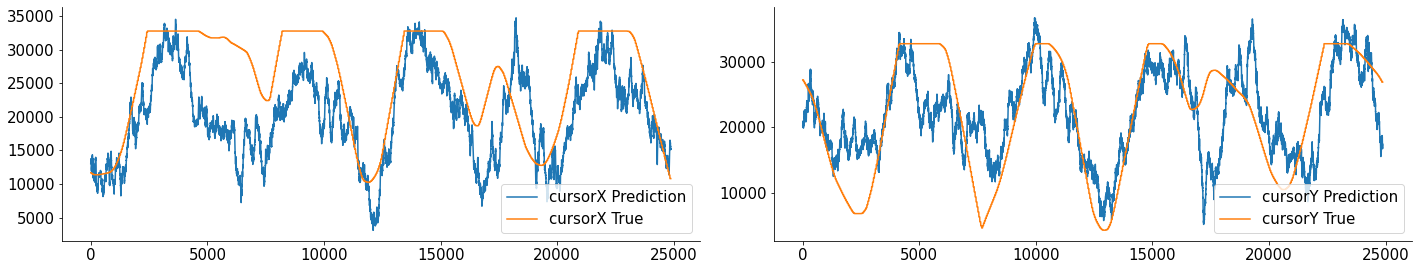

In [211]:
#Generate and visualise response
h=4
l=500
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)


plt.figure()
plt.subplot(1, 2, 1)
plt.plot(prediction[:,0], label='cursorX Prediction')
plt.plot(truth[:,0], label='cursorX True')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prediction[:,1], label='cursorY Prediction')
plt.plot(truth[:,1], label='cursorY True')
plt.legend()




In [281]:
# Create linear regression prediction, return RMS value 
def LR_RMS(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    truth, prediction = LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l)
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

def LR_RMS_norm(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    truth, prediction = LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l)
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    
    #Normalise by sample length
    _rms_norm = _rms/len(prediction)
    return _rms_norm

<AxesSubplot:>

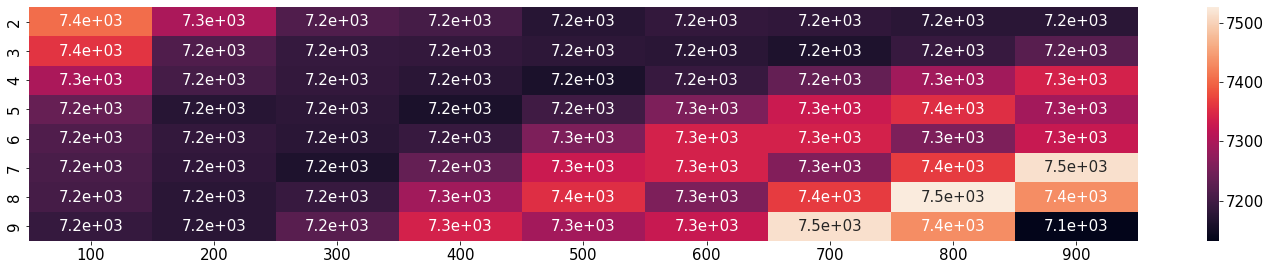

In [282]:
# RMS heatmap, total RMS (not normalised)

hs = range(2, 10)
ls = range(100, 1000, 100)
rmss = np.zeros((len(hs), len(ls)))
for i, h in enumerate(hs):
    for j, l in enumerate(ls):
        rms = LR_RMS(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
        rmss[i, j] = rms
        
sns.heatmap(rmss, annot=True, xticklabels=ls, yticklabels=hs)


<AxesSubplot:>

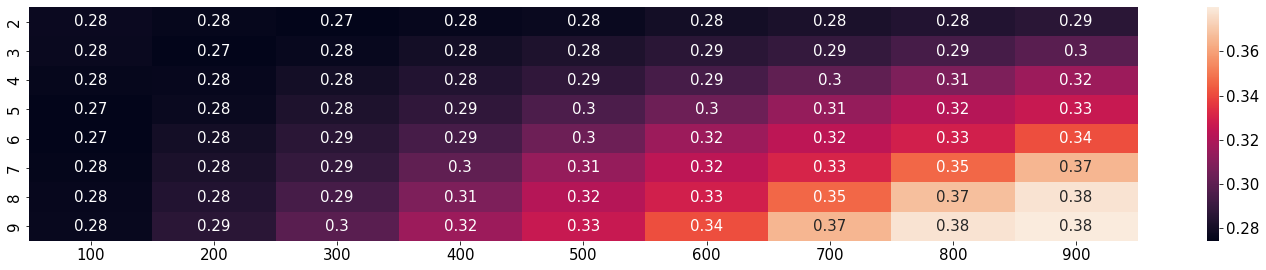

In [283]:
# RMS heatmap, average RMS (normalised)

hs = range(2, 10)
ls = range(100, 1000, 100)
rmss = np.zeros((len(hs), len(ls)))
for i, h in enumerate(hs):
    for j, l in enumerate(ls):
        rms = LR_RMS_norm(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
        rmss[i, j] = rms
        
sns.heatmap(rmss, annot=True, xticklabels=ls, yticklabels=hs)
